## Import libraries

In [1]:
# For data manipulation
# For linear algebra
# For Technical Analysis
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
import investpy
import talib
from ta.trend import ADXIndicator
from finta import TA
import TradingSignals
import AlgorithmicTrading
import Backtesting
import Position
import pyfolio as pf

# For visualization
import matplotlib.pyplot as plt
import visualize
#import plotly.graph_objects as go
%matplotlib inline

# Set color style
plt.style.use('seaborn-dark')
plt.style.use('tableau-colorblind10')

# Set bold-line style
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## Data

<ins>**Precious Metals**</ins>

We are going to choose and focus on one of the intriguing price charts for precious metals data. Exceptional, naturally found metals with considerable economic worth are known as precious metals. They are distinctive in that they have both industrial and trade aspects. `Gold`, `silver`, `platinum`, and `palladium` are among the precious metals with competitive commodities markets. 

In [2]:
# Commodity Prices period 
start_date = '01/01/2006'
end_date = '31/12/2020'

# Commodity Traded Country
country = 'united states'

In [3]:
# Commodity, Precious metals data
Gold = investpy.get_commodity_historical_data('gold', start_date, end_date, country)
Silver = investpy.get_commodity_historical_data('silver', start_date, end_date, country)
Platinum = investpy.get_commodity_historical_data('platinum', start_date, end_date, country)
Palladium = investpy.get_commodity_historical_data('palladium', start_date, end_date, country)

In [4]:
# Combine all precious metals price data
df = pd.concat([Gold, Silver, Platinum, Palladium], axis=1,keys=['Gold', 'Silver', 'Platinum', 'Palladium'])
df.columns.names = ['Metal Name', 'Commodity Info']
df.head()

Metal Name       Gold                                      Silver         \
Commodity Info   Open   High    Low  Close Volume Currency   Open   High   
Date                                                                       
2006-01-03      2.160  2.166  2.122  2.168  682.0      USD  2.160  2.166   
2006-01-04      2.160  2.230  2.160  2.216  537.0      USD  2.160  2.230   
2006-01-05      2.212  2.212  2.132  2.139  554.0      USD  2.212  2.212   
2006-01-06      2.150  2.159  2.119  2.155  704.0      USD  2.150  2.159   
2006-01-09      2.168  2.170  2.167  2.167  286.0      USD  2.168  2.170   

Metal Name                    ... Platinum                       Palladium  \
Commodity Info    Low  Close  ...      Low Close Volume Currency      Open   
Date                          ...                                            
2006-01-03      2.122  2.168  ...      NaN   NaN    NaN      NaN       NaN   
2006-01-04      2.160  2.216  ...      NaN   NaN    NaN      NaN       NaN   
2006-01-05      2.132  2.139  ...      NaN   NaN    NaN      NaN       NaN   
2006-01-06      2.119  2.155  ...      NaN   NaN    NaN      NaN       NaN   
2006-01-09      2.167  2.167  ...      NaN   NaN    NaN      NaN       NaN   

Metal Name                                     
Commodity Info High Low Close Volume Currency  
Date                                           
2006-01-03      NaN NaN   NaN    NaN      NaN  
2006-01-04      NaN NaN   NaN    NaN      NaN  
2006-01-05      NaN NaN   NaN    NaN      NaN  
2006-01-06      NaN NaN   NaN    NaN      NaN  
2006-01-09      NaN NaN   NaN    NaN      NaN  

[5 rows x 24 columns]

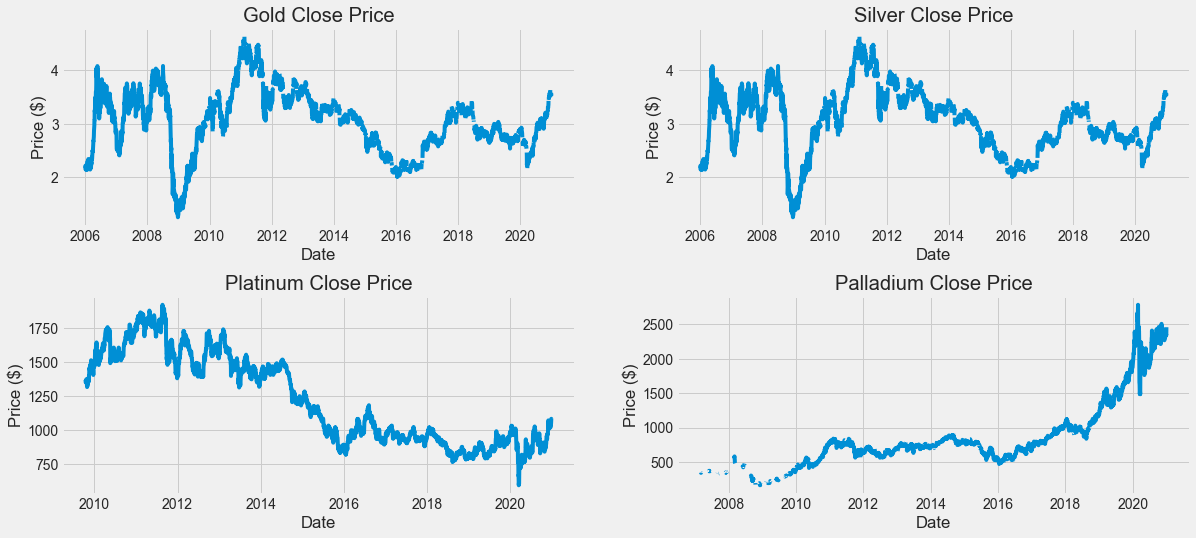

In [5]:
# Plotting close price data
fig, axs = plt.subplots(2,2, figsize=(18,8))
fig.subplots_adjust(hspace=0.35)

# Gold 
axs[0,0].plot(df.Gold['Close'])
axs[0,0].set_title('Gold Close Price')
axs[0,0].set_ylabel('Price ($)')
axs[0,0].set_xlabel('Date')

# Silver
axs[0,1].plot(df.Silver['Close'])
axs[0,1].set_title('Silver Close Price')
axs[0,1].set_ylabel('Price ($)')
axs[0,1].set_xlabel('Date')

# Platinum
axs[1,0].plot(df.Platinum['Close'])
axs[1,0].set_title('Platinum Close Price')
axs[1,0].set_ylabel('Price ($)')
axs[1,0].set_xlabel('Date')

# Palladium
axs[1,1].plot(df.Palladium['Close'])
axs[1,1].set_title('Palladium Close Price')
axs[1,1].set_ylabel('Price ($)')
axs[1,1].set_xlabel('Date')
plt.show()

From 2006 through 2020, the above depiction of price dates for all precious metals illustrates that `gold` and `silver` have virtually identical prices. `Platinum` and `palladium`, on the other hand, both have a missing value in the years 2006 and 2007, because the author of my study wants to focus on the years 2006 to 2020, which includes the economic recession of 2008 and COVID-19 pandemic.

It must be continued by using gold as a metal commodity price in the research, despite the fact that its prices are very comparable to silver's and all precious metals are extremely liquid, making it an excellent approach to test algorithmic trading in commodity future markets. 

-------

## Trend Analysis

Trend analysis is a technical analysis approach that aims to anticipate future price movements using trend data that has recently been seen. Trend analysis forecasts the long-term pattern of price action using past data, including price changes and transaction volume.

<ins>__Type of trends:__</ins>
- `Uptrend` - when the direction of an asset price movement keeps rising, it is referred to as a "bull market".
- `Downtrend` - when the direction of an asset price movement keeps declining, it is referred to as a "bear market".
- `Sideways trend` - when the forces of supply and demand are roughly equivalent, a horizontal price movement occurs, it is referred to as a "choppy market".

The research is focused on trading on all long-term trends, using technical indicators such as the `Simple Moving Average (SMA)`, `Average Directional Index`, and `Adaptive Price Zone` to generate combinations of all the strategies mentioned. 

### Price and Volume Charts

A price chart is a graph that shows a series of prices through time. Time series plots are how charts are referred to in statistics. The price scale is represented by the y-axis (vertical axis) on the chart, while the time scale is represented by the x-axis (horizontal axis). The bottom of a commodity price chart usually reflects volume. Trading volume is depicted in a horizontal line plot on the charts, with the plot displaying how many shares moved. 

In [6]:
# Check NaN values for Gold price data
Gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3814 entries, 2006-01-03 to 2020-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      3814 non-null   float64
 1   High      3814 non-null   float64
 2   Low       3814 non-null   float64
 3   Close     3814 non-null   float64
 4   Volume    3814 non-null   int64  
 5   Currency  3814 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 337.6+ KB


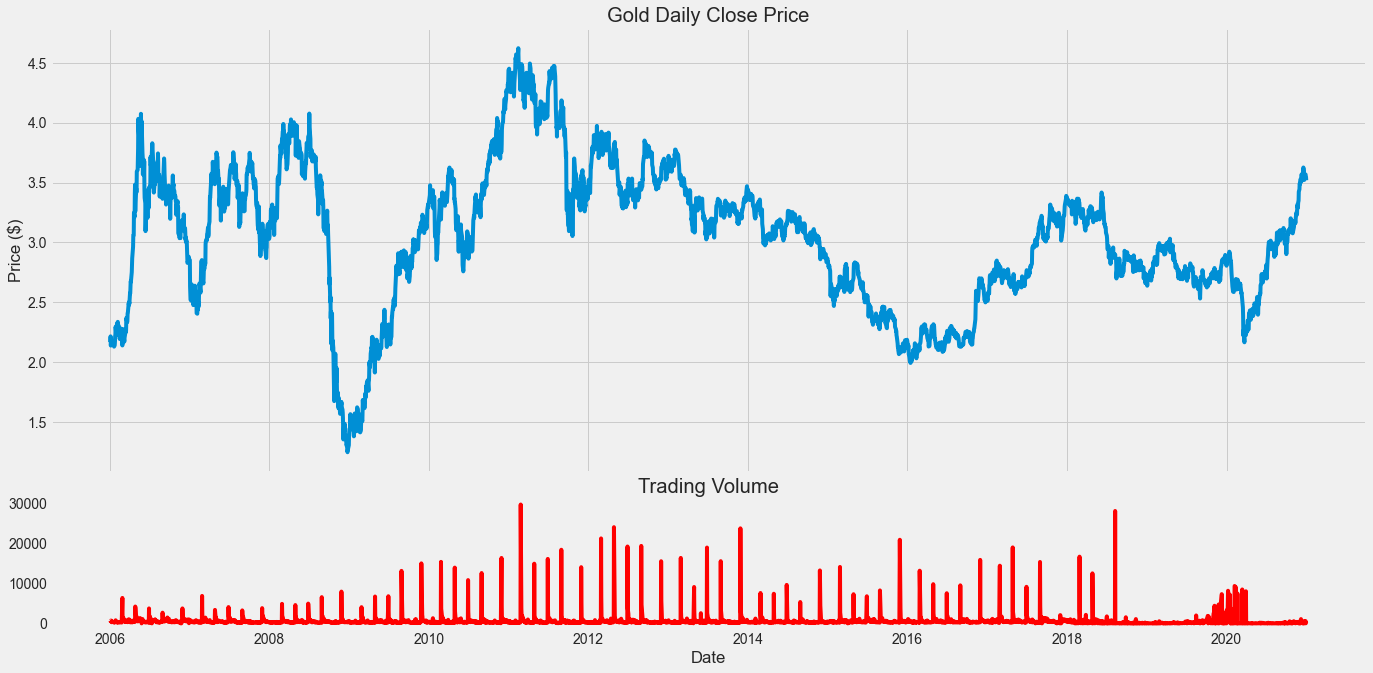

In [7]:
# Plottong the price and Volume
top = plt.subplot2grid((5,4), (0,0), rowspan=3, colspan=4)
top.plot(Gold.index, Gold['Close'])
bottom = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4, sharex=top)
bottom.plot(Gold.index, Gold['Volume'], c='red')
top.set_title('Gold Daily Close Price')
bottom.set_title('Trading Volume')
top.set_ylabel('Price ($)')
bottom.set_xlabel('Date')
plt.setp(top.get_xticklabels(), visible=False)
plt.grid(False)
plt.gcf().set_size_inches(21,13)

Gold commodities are handled in excess, and the profitability varies depending on market uncertainty and the contract's current market price. Competitively, gold is used as a covering on interconnects. Even though the market for gold changes in the short term, it has always held its worth in the long run. It has worked as a hedge against rising prices and the depreciation of world currencies over the period, making it a good investment. 

The plots above show the relationship and dependencies between the prices and volume trades, with non-trending from 2006 to 2009, non-trending during the economic crisis, and non-trending from 2019 to 2020. Bullish and bearish market movements may be seen in the charts from 2009 to 2019. 

__Simple Moving Average (SMA)__

It is the average price for a given period of time. Since it is shown on the charts, generating a line that flows along the map as the average result varies, the mean is called "moving". A 200-day simple moving average is a long-term indicator that is commonly used to determine long-term trends and 20-day simple moving average for short term trends, which are going to be used in the study for crossover strategy.

In [8]:
# Compute short-period simple moving average indicator
SMA20 = talib.SMA(Gold['Close'], timeperiod=20)

# Compute long-period simple moving average indicator
SMA200 = talib.SMA(Gold['Close'], timeperiod=200)

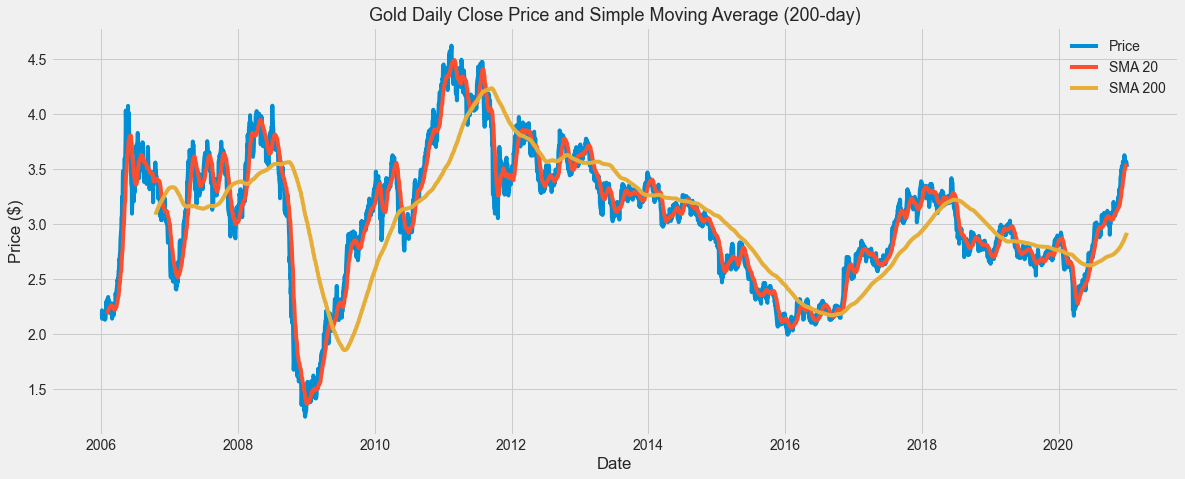

In [9]:
# Plotting the price and simple moving average
visualize.SMA(Gold, SMA20, SMA200)

With the gold daily closing prices, we've drawn the short-term SMA values and long-term SMA values above. The gold closing prices are represented by the blue line, while the red and gold lines represent the SMA 20 and SMA 200, respectively. Because the given period of time for the golden line's values is significantly higher than the particular timeframe for the red line's values, the golden line, SMA 200, is noticeably smoother than the red line, SMA 20. 

__Average Directional Index (ADX)__

The average directional index (ADX) is a technical indicator that some traders use to evaluate the strength of a trend. It may help traders minimize risk while also increasing profitability. 

In [10]:
# Compute average directional index indicator
adxI = ADXIndicator(Gold['High'], Gold['Low'], Gold['Close'], window=14)

# Compute average directional index (ADX)
adx = adxI.adx()

# Compute positive directional index (+DI)
positive_DI = adxI.adx_pos()

# Compute negative directional index (-DI)
negative_DI = adxI.adx_neg()

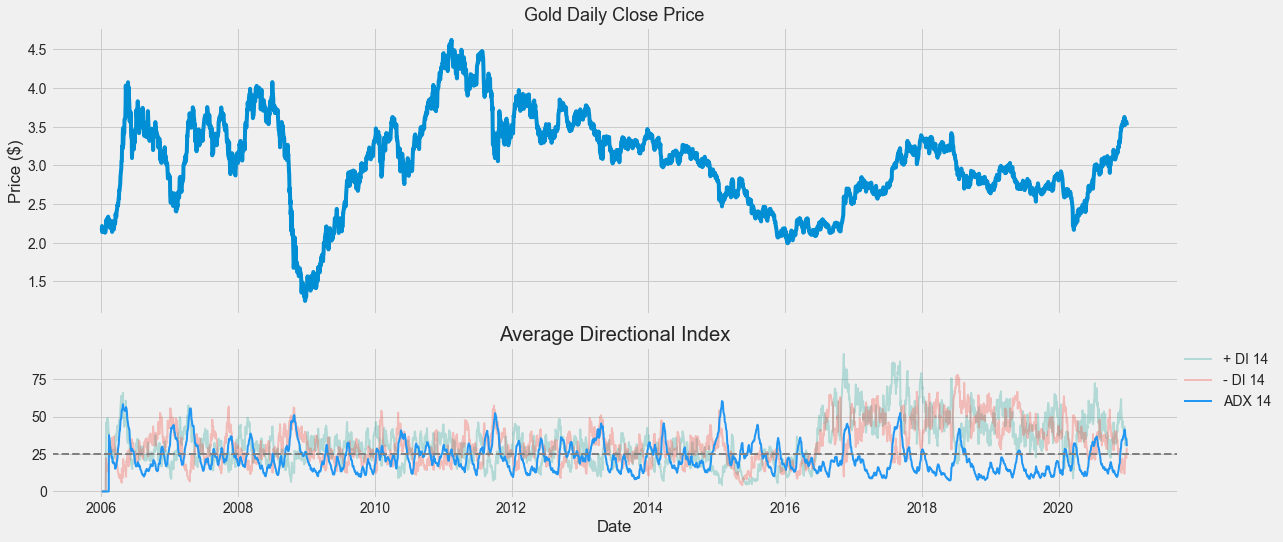

In [11]:
# Plotting the price and average directional index
visualize.ADX(Gold, adx, positive_DI, negative_DI)

The plot above is divided into two panels, the top chart represents gold closing pricing, while the bottom chart shows the ADX components. A grey dashed line is drawn alongside the components, and it is nothing more than the ADX threshold drawn at a value of 25. The ADX line grows when the market is in a clear trend whether increasing or decreasing and lowers when the market is about to break, as shown on numerous occasions in the plot. This is also true for both these directional index lines. We can observe that the +DI line rises during a strong uptrend and declines throughout a severe downturn, and conversely for the -DI line. 

__Adaptive Price Zone (APZ)__

The adaptive price zone (APZ) is a price movements measurement tool that can assist traders spot potential market pivotal moments, which is particularly valuable in a choppy market. 

In [12]:
# Define the single smooth of exponential moving average for 20-period
ema = pd.Series(Gold['Close'].ewm(span=20, adjust=True).mean())
# Define the single smooth of exponential moving average for 20-period
dema = pd.Series(ema.ewm(span=20, adjust=True).mean(), name='DEMA')

In [13]:
# Price range of high prices and low prices for 20-perid
price_range = pd.Series((Gold['High'] - Gold['Low']).ewm(span=20, adjust=True).mean())
# Volatility value
volatility_value = pd.Series(price_range.ewm(span=20, adjust=True).mean(), name='Volatility')

In [14]:
# Calculations of upper band and lower band
upper_APZ_band = pd.Series((10 * volatility_value) + dema, name="upperband")
lower_APZ_band = pd.Series(dema - (10 * volatility_value), name="lowerband")

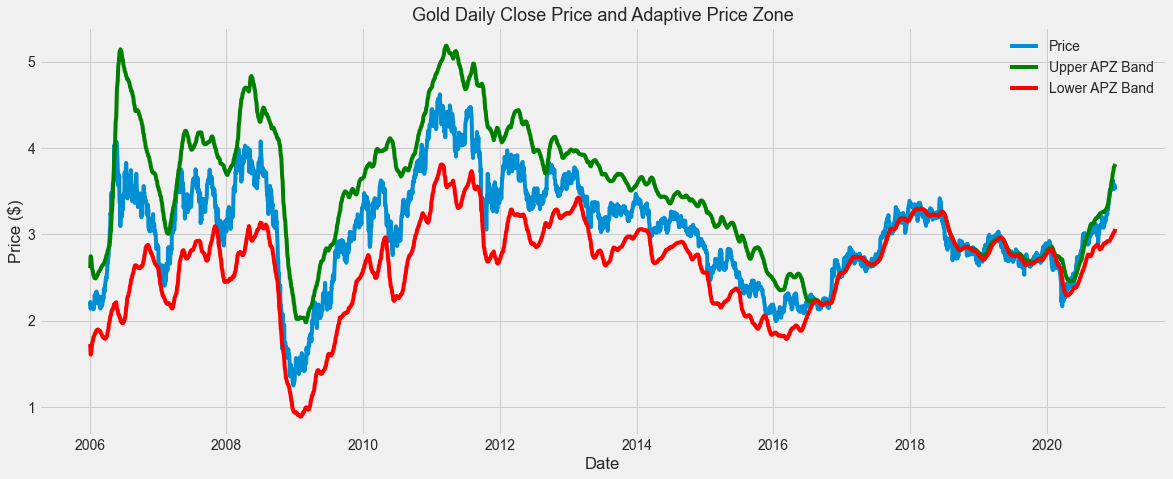

In [15]:
# Plotting the price and adaptive price zone
visualize.APZ(Gold, lower_APZ_band, upper_APZ_band)

APZ Bands are useful for observing the volatility of a certain security over a certain timeframe on a price chart. The APZ bands incorporate volatility into account and move in structure and width (distance from each other) when price movement varies. The distance between the upper and lower APZ bands will often widen with higher price fluctuations and narrow during periods of low price movement. As a result, wide bands indicate higher volatility, whereas tight bands indicate lower volatility. 

------------

## Build Algorithmic Trading

Algorithmic trading is a way of identifying and validating factors such as time, price, and volume using computerized methods, which was before trading instructions. This trading condition tries to make use of algorithms' speed and processing capacity in comparison to human trading. The following strategies are to be used before all combined so that they can trade in all trends, including choppy markets:

- SMA Strategy
- ADX Strategy
- APZ Strategy

<ins>__Trading Strategy (SMA Crossover)__</ins>

We are going to create a simple moving average crossover strategy in which the algorithm places a trade when a shorter-period SMA passes over a longer-period SMA. Similarly, when the SMA determined over a longer period passes over the SMA determined over a shorter period, the algorithm sells the commodity.

In [16]:
# Compute simple moving average crossover strategy
sma_buy, sma_sell, sma_signal = AlgorithmicTrading.SMA_CrossOver(Gold['Close'], SMA20, SMA200)

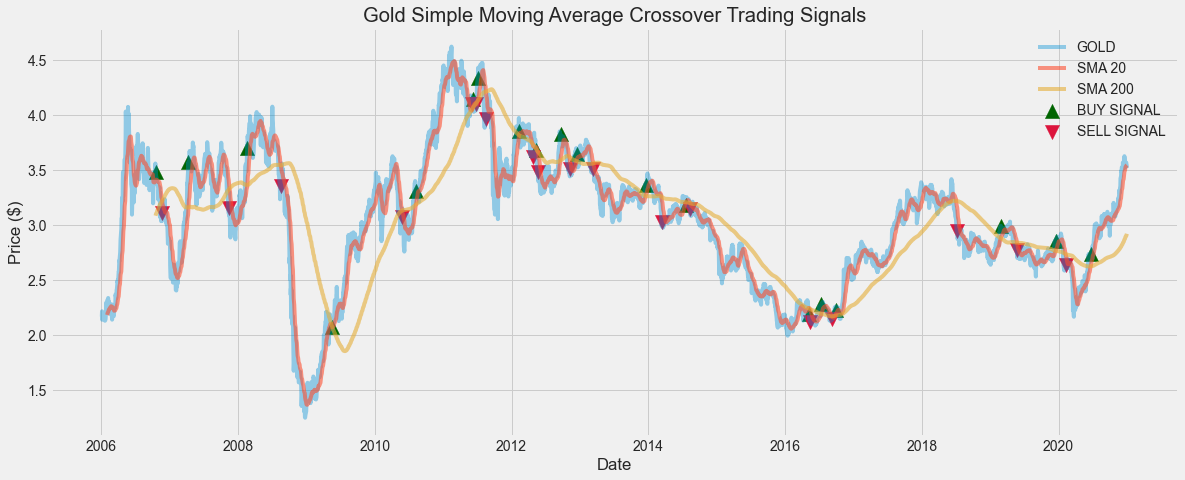

In [17]:
# Plotting simple moving average crossover strategy trading signal
TradingSignals.SMA_Crossover(Gold, SMA20, SMA200, sma_buy, sma_sell)

<ins>__Trading Strategy (ADX)__</ins>

We are going to create a average directional index strategy in this part that shows a buying signal anytime the ADX line passes under it to over 25 and the +DI line is above the -DI line. A sell signal is generated when the ADX line falls below 25 and the -DI line rises above the +DI line. 

In [18]:
# Compute simple moving average crossover strategy
adx_buy, adx_sell, adx_signal = AlgorithmicTrading.ADX(Gold['Close'], adx, positive_DI, negative_DI)

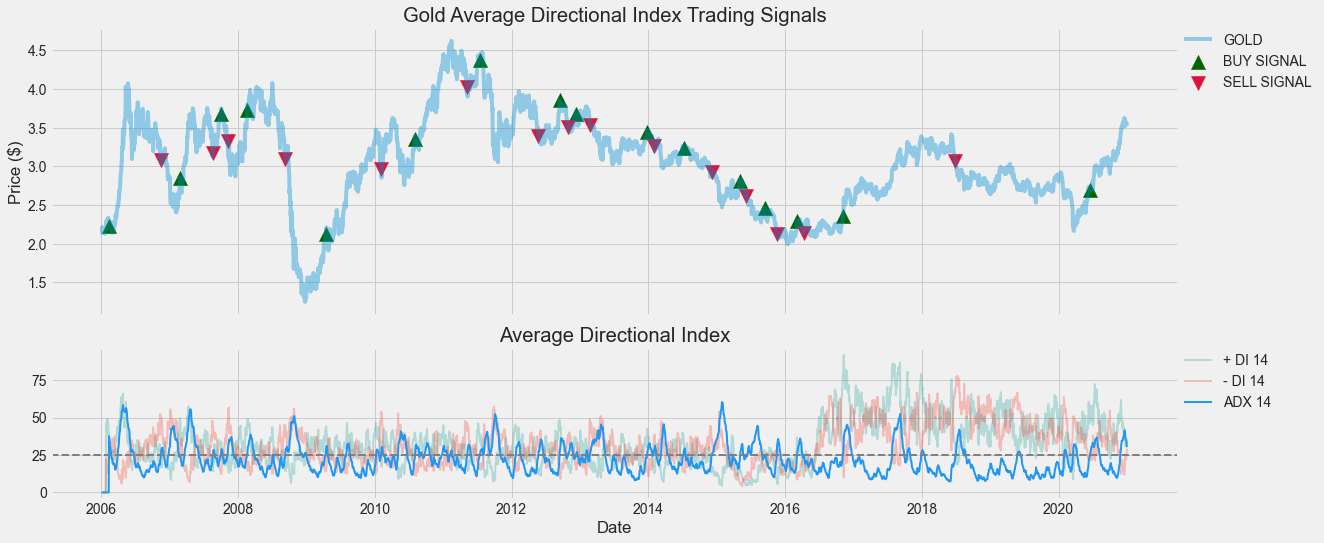

In [19]:
# Plotting simple moving average crossover strategy trading signal
TradingSignals.ADX(Gold, adx, positive_DI, negative_DI, adx_buy, adx_sell)

<ins>__Trading Strategy (APZ)__</ins>

The APZ indicator may be used to any market or charting period, but it performs in choppy, non-trending markets.
When prices exceeds the upper APZ band, establish a sell order, alternatively, when prices exceeds the lower APZ band, execute a buy order. 

In [20]:
# Compute adaptive price zone strategy
apz_buy, apz_sell, apz_signal = AlgorithmicTrading.APZ(Gold, adx, lower_APZ_band, upper_APZ_band)

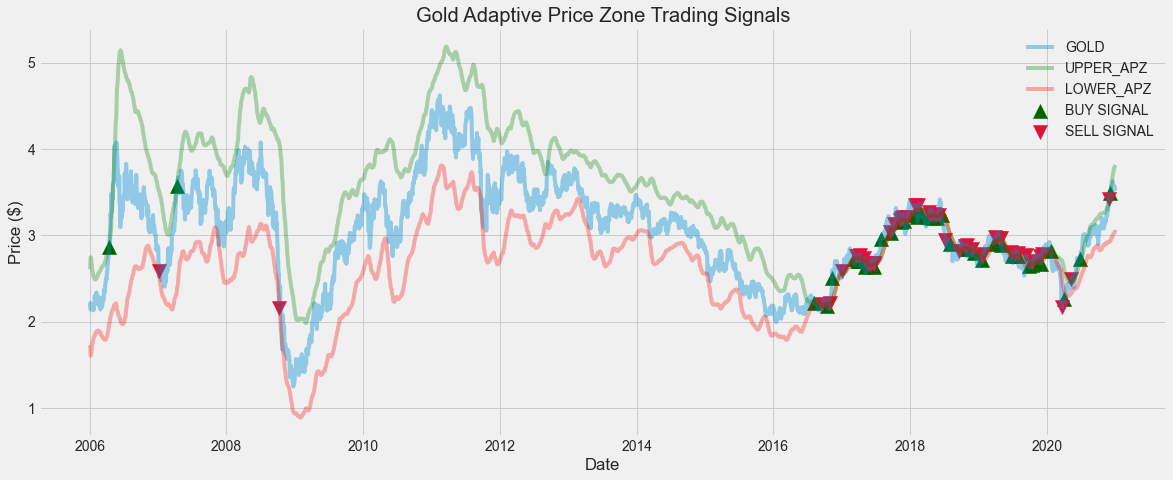

In [21]:
# Plotting adaptive price zone strategy trading signal
TradingSignals.APZ(Gold, lower_APZ_band, upper_APZ_band, apz_buy, apz_sell)

----

## Backtesting

Backtesting is a way of determining how well a strategy or paradigm would have performed in the absence of the strategy or model. Backtesting allows a trader to obtain outcomes and measure risk and profitability without losing any real money by simulating a trading strategy using previous data. 

The strategies below can be backtested with any amount of money or capital, but I'm going to use $150,000 as the actual capital to compare profitabilities without transaction costs to see if they result in a gain or loss.

<ins>__Simple Moving Average Crossover Strategy__</ins>

In this approach, we are going to use gold price data to backtest our Simple Moving Average Crossover trading strategy.

In [22]:
# Define positions from simple moving average strategy
sma_position = Position.order(Gold, sma_signal)

In [23]:
# Create simple moving average strategy data-frame
sma20 = pd.DataFrame(SMA20).rename(columns = {0:'sma20'})
sma200 = pd.DataFrame(SMA200).rename(columns = {0:'sma200'})
sma_signal = pd.DataFrame(sma_signal).rename(columns = {0:'signal'}).set_index(Gold.index)
sma_position = pd.DataFrame(sma_position).rename(columns = {0:'position'}).set_index(Gold.index)
sma_frames = [Gold, sma20, sma200, sma_signal, sma_position]
sma_strategy = pd.concat(sma_frames, join = 'inner', axis = 1)
sma_strategy.tail()

,Open,High,Low,Close,Volume,Currency,sma20,sma200,signal,position
Date,,,,,,,,,,
2020-12-24,3.5520,3.5655,3.5520,3.5615,66,USD,3.529375,2.895097,0,1
2020-12-28,3.5860,3.6170,3.5810,3.5685,573,USD,3.536600,2.901700,0,1
2020-12-29,3.5675,3.5690,3.5640,3.5520,23,USD,3.541950,2.908107,0,1
2020-12-30,3.5495,3.5755,3.5495,3.5485,228,USD,3.544750,2.914607,0,1
2020-12-31,3.5340,3.5340,3.5245,3.5200,37,USD,3.546400,2.920997,0,1


In [24]:
# Backtesting for simple moving average strategy
Backtesting.implementation(Gold, sma_strategy, 150000, 'SMA')

Profit gained from the SMA strategy by investing $150K in Gold : $48088.77
Profit percentage of the SMA strategy : 32%


----

<ins>__Average Directional Index Strategy__</ins>

In this approach, we are going to use gold price data to backtest our Average Directional Index trading strategy. 

In [25]:
# Define positions from average directional index strategy
adx_position = Position.order(Gold, adx_signal)

In [26]:
# Create average directional index strategy data-frame
adx_signal = pd.DataFrame(adx_signal).rename(columns = {0:'signal'}).set_index(Gold.index)
adx_position = pd.DataFrame(adx_position).rename(columns = {0:'position'}).set_index(Gold.index)
adx_frames = [Gold, adx, positive_DI, negative_DI, adx_signal, adx_position]
adx_strategy = pd.concat(adx_frames, join = 'inner', axis = 1)
adx_strategy.tail()

,Open,High,Low,Close,Volume,Currency,adx,adx_pos,adx_neg,signal,position
Date,,,,,,,,,,,
2020-12-24,3.5520,3.5655,3.5520,3.5615,66,USD,35.582187,30.756288,24.197064,0,1
2020-12-28,3.5860,3.6170,3.5810,3.5685,573,USD,34.711696,35.804840,22.227899,0,1
2020-12-29,3.5675,3.5690,3.5640,3.5520,23,USD,33.513693,35.524356,24.717223,0,1
2020-12-30,3.5495,3.5755,3.5495,3.5485,228,USD,32.072490,34.031444,26.022184,0,1
2020-12-31,3.5340,3.5340,3.5245,3.5200,37,USD,30.187238,32.666747,29.155861,0,1


In [27]:
# Backtesting for average directional index strategy
Backtesting.implementation(Gold, adx_strategy, 150000, 'ADX')

Profit gained from the ADX strategy by investing $150K in Gold : $28550.71
Profit percentage of the ADX strategy : 19%


----

<ins>__Adaptive Price Zone Strategy__</ins>

In this approach, we are going to use gold price data to backtest our Adaptive Price Zone trading strategy. 

In [28]:
# Define positions from adaptive price zone strategy
apz_position = Position.order(Gold, apz_signal)

In [29]:
# Create average adaptive price zone strategy data-fame
apz_signal = pd.DataFrame(apz_signal).rename(columns = {0:'signal'}).set_index(Gold.index)
apz_position = pd.DataFrame(apz_position).rename(columns = {0:'position'}).set_index(Gold.index)
apz_frames = [Gold, adx, lower_APZ_band, upper_APZ_band, apz_signal, apz_position]
apz_strategy = pd.concat(apz_frames, join = 'inner', axis = 1)
apz_strategy.tail()

,Open,High,Low,Close,Volume,Currency,adx,lowerband,upperband,signal,position
Date,,,,,,,,,,,
2020-12-24,3.5520,3.5655,3.5520,3.5615,66,USD,35.582187,3.025010,3.779368,0,1
2020-12-28,3.5860,3.6170,3.5810,3.5685,573,USD,34.711696,3.031697,3.793400,0,1
2020-12-29,3.5675,3.5690,3.5640,3.5520,23,USD,33.513693,3.041438,3.803151,0,1
2020-12-30,3.5495,3.5755,3.5495,3.5485,228,USD,32.072490,3.051652,3.811181,0,1
2020-12-31,3.5340,3.5340,3.5245,3.5200,37,USD,30.187238,3.063400,3.815975,0,1


In [30]:
# Backtesting for adaptive price zone strategy
Backtesting.implementation(Gold, apz_strategy, 150000, 'APZ')

Profit gained from the APZ strategy by investing $150K in Gold : $25525.19
Profit percentage of the APZ strategy : 17%


---

<ins>__SMA-ADX-APZ Strategy__</ins>

In this approach, we are going to use gold price data to backtest our combination SMA-ADX-APZ trading strategy. 

In [31]:
# Compute SMA-ADX-APZ strategy
buy, sell, signal = AlgorithmicTrading.SMA_ADX_APZ(Gold, SMA20, SMA200, adx, positive_DI,
                               negative_DI, lower_APZ_band,upper_APZ_band)

In [32]:
# Define positions from SMA-ADX-APZ strategy
position = Position.order(Gold, signal)

In [33]:
# Create SMA-ADX-APZ strategy data-fame
signal = pd.DataFrame(signal).rename(columns = {0:'signal'}).set_index(Gold.index)
position = pd.DataFrame(position).rename(columns = {0:'position'}).set_index(Gold.index)
all_strategy_df = pd.merge(pd.merge(sma_strategy, adx_strategy[['adx', 'adx_pos', 'adx_neg']],
                                    left_index=True, right_index=True, how="outer").drop(['signal','position'], axis=1),
                           apz_strategy[['lowerband', 'upperband']], left_index=True, right_index=True, how="outer")
sma_adx_apz_frames = [all_strategy_df, signal, position]
sma_adx_apz_strategy = pd.concat(sma_adx_apz_frames, join = 'inner', axis = 1)
sma_adx_apz_strategy.tail()

,Open,High,Low,Close,Volume,Currency,sma20,sma200,adx,adx_pos,adx_neg,lowerband,upperband,signal,position
Date,,,,,,,,,,,,,,,
2020-12-24,3.5520,3.5655,3.5520,3.5615,66,USD,3.529375,2.895097,35.582187,30.756288,24.197064,3.025010,3.779368,0,1
2020-12-28,3.5860,3.6170,3.5810,3.5685,573,USD,3.536600,2.901700,34.711696,35.804840,22.227899,3.031697,3.793400,0,1
2020-12-29,3.5675,3.5690,3.5640,3.5520,23,USD,3.541950,2.908107,33.513693,35.524356,24.717223,3.041438,3.803151,0,1
2020-12-30,3.5495,3.5755,3.5495,3.5485,228,USD,3.544750,2.914607,32.072490,34.031444,26.022184,3.051652,3.811181,0,1
2020-12-31,3.5340,3.5340,3.5245,3.5200,37,USD,3.546400,2.920997,30.187238,32.666747,29.155861,3.063400,3.815975,0,1


In [34]:
# Backtesting for SMA-ADX-APZ strategy
Backtesting.implementation(Gold, sma_adx_apz_strategy, 150000, 'SMA-ADX-APZ')

Profit gained from the SMA-ADX-APZ strategy by investing $150K in Gold : $57612.78
Profit percentage of the SMA-ADX-APZ strategy : 38%


----

## Performance Statistics

An algorithm's performance is analyzed to see how effective it is in comparison to another strategy that handles the very same application challenge. Programmers may develop better and more efficient algorithms by using efficient algorithms.

The pyfolio package includes an abundance of performance information that most professional institutional investors would use to evaluate the algorithm's success. The algorithm's daily, monthly, and yearly returns, yield summary statistics, and sharpe ratios, as well as the portfolio's volatility, are among these indicators. The following statistics in a data frame are the most important metrics to consider.

In [35]:
# Calculate daily returns of Gold
returns = Gold.Close.pct_change()

# Calculate daily strategy returns
sma_returns = (returns * sma_strategy.position.shift(1)).dropna()
adx_returns = (returns * adx_strategy.position.shift(1)).dropna()
apz_returns = (returns * apz_strategy.position.shift(1)).dropna()
sma_adx_apz_returns = (returns * sma_adx_apz_strategy.position.shift(1)).dropna()

# Calculate the performance statistics of strategies
sma_perf_stats = pf.timeseries.perf_stats(sma_returns) 
adx_perf_stats = pf.timeseries.perf_stats(adx_returns)
apz_perf_stats = pf.timeseries.perf_stats(apz_returns) 
sma_adx_apz_perf_stats = pf.timeseries.perf_stats(sma_adx_apz_returns)

In [36]:
# Concatenate all strategies performance statistics
df = pd.concat([sma_perf_stats, adx_perf_stats, apz_perf_stats, sma_adx_apz_perf_stats], axis=1)

# Rename to the correct columns
df = df.rename(columns = {0:'SMA Backtest', 1:'ADX Backtest', 2:'APZ Backtest',3:'SMA-ADX-APZ Backtest'})

# Create a variable to format the subsets to percentage sign rounded-off to 1 decimal
formatter = {'Annual return': '{:.1%}',
             'Cumulative returns': '{:.1%}',
             'Annual volatility': '{:.1%}',
             'Max drawdown': '{:.1%}',
             'Daily value at risk': '{:.1%}'}

# Performance statistics data-frame of trading strategies with 2 decimals and 1 decimal for percentages (%)
performance_statistics = df.T.style.format(formatter, precision=2)
performance_statistics

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
SMA Backtest,3.8%,75.4%,18.6%,0.29,0.07,0.01,-51.0%,1.07,0.42,0.14,9.09,1.08,-2.3%
ADX Backtest,2.6%,48.0%,19.6%,0.23,0.04,0.34,-62.3%,1.06,0.33,0.16,8.35,1.05,-2.4%
APZ Backtest,1.3%,21.3%,17.0%,0.16,0.02,0.03,-63.2%,1.05,0.22,-0.49,18.22,1.11,-2.1%
SMA-ADX-APZ Backtest,3.3%,62.4%,28.0%,0.25,0.05,0.04,-69.4%,1.05,0.37,0.07,4.25,1.02,-3.5%


<ins>Sources:</ins>

1. https://commodity.com/precious-metals/
2. https://www.motilaloswal.com/blog-details/The-power-of-evergreen-investment-destination-(Gold-Commodity)/1070
3. https://www.investopedia.com/articles/basics/08/reasons-to-own-gold.asp
4. https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/sma
5. https://www.investopedia.com/terms/a/adx.asp
6. https://www.investopedia.com/articles/trading/10/adaptive-price-zone-indicator-explained.asp